In [27]:
%load_ext autoreload
%autoreload 3
from Probe import probe_shapelet
from utils.insert_shapelet import get_pdata, insert_random, overwrite_shaplet_random
from utils.utils import pickle_load_from_file
import numpy as np
import utils
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from dtaidistance import dtw_ndim
from dtaidistance.subsequence.dtw import subsequence_alignment


from tqdm import tqdm, trange

warnings.filterwarnings("ignore")
from utils import *

from tsai.models.FCN import FCN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_name = 'FCN'
task = 'GunPoint'
explainer = 'Saliency'
implets_save_dir = f'./output/{model_name}/{task}/{explainer}'
implets_list = pickle_load_from_file(os.path.join(implets_save_dir, 'implets.pkl'))

In [3]:
from tsai.models.FCN import FCN

device = 'cuda'
model_path = f'models/{model_name}/{task}/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt', map_location=device)
model.load_state_dict(state_dict)
model.eval()

train_x, test_x, train_y, test_y, enc1 = read_UCR_UEA(task, None)

test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)
preds = np.load(f'{model_path}/test_preds.npy')

In [4]:

with open(f'attributions/{model_name}/{task}/{explainer}/test_exp.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_gp = attr['attributions']

Pred y:0


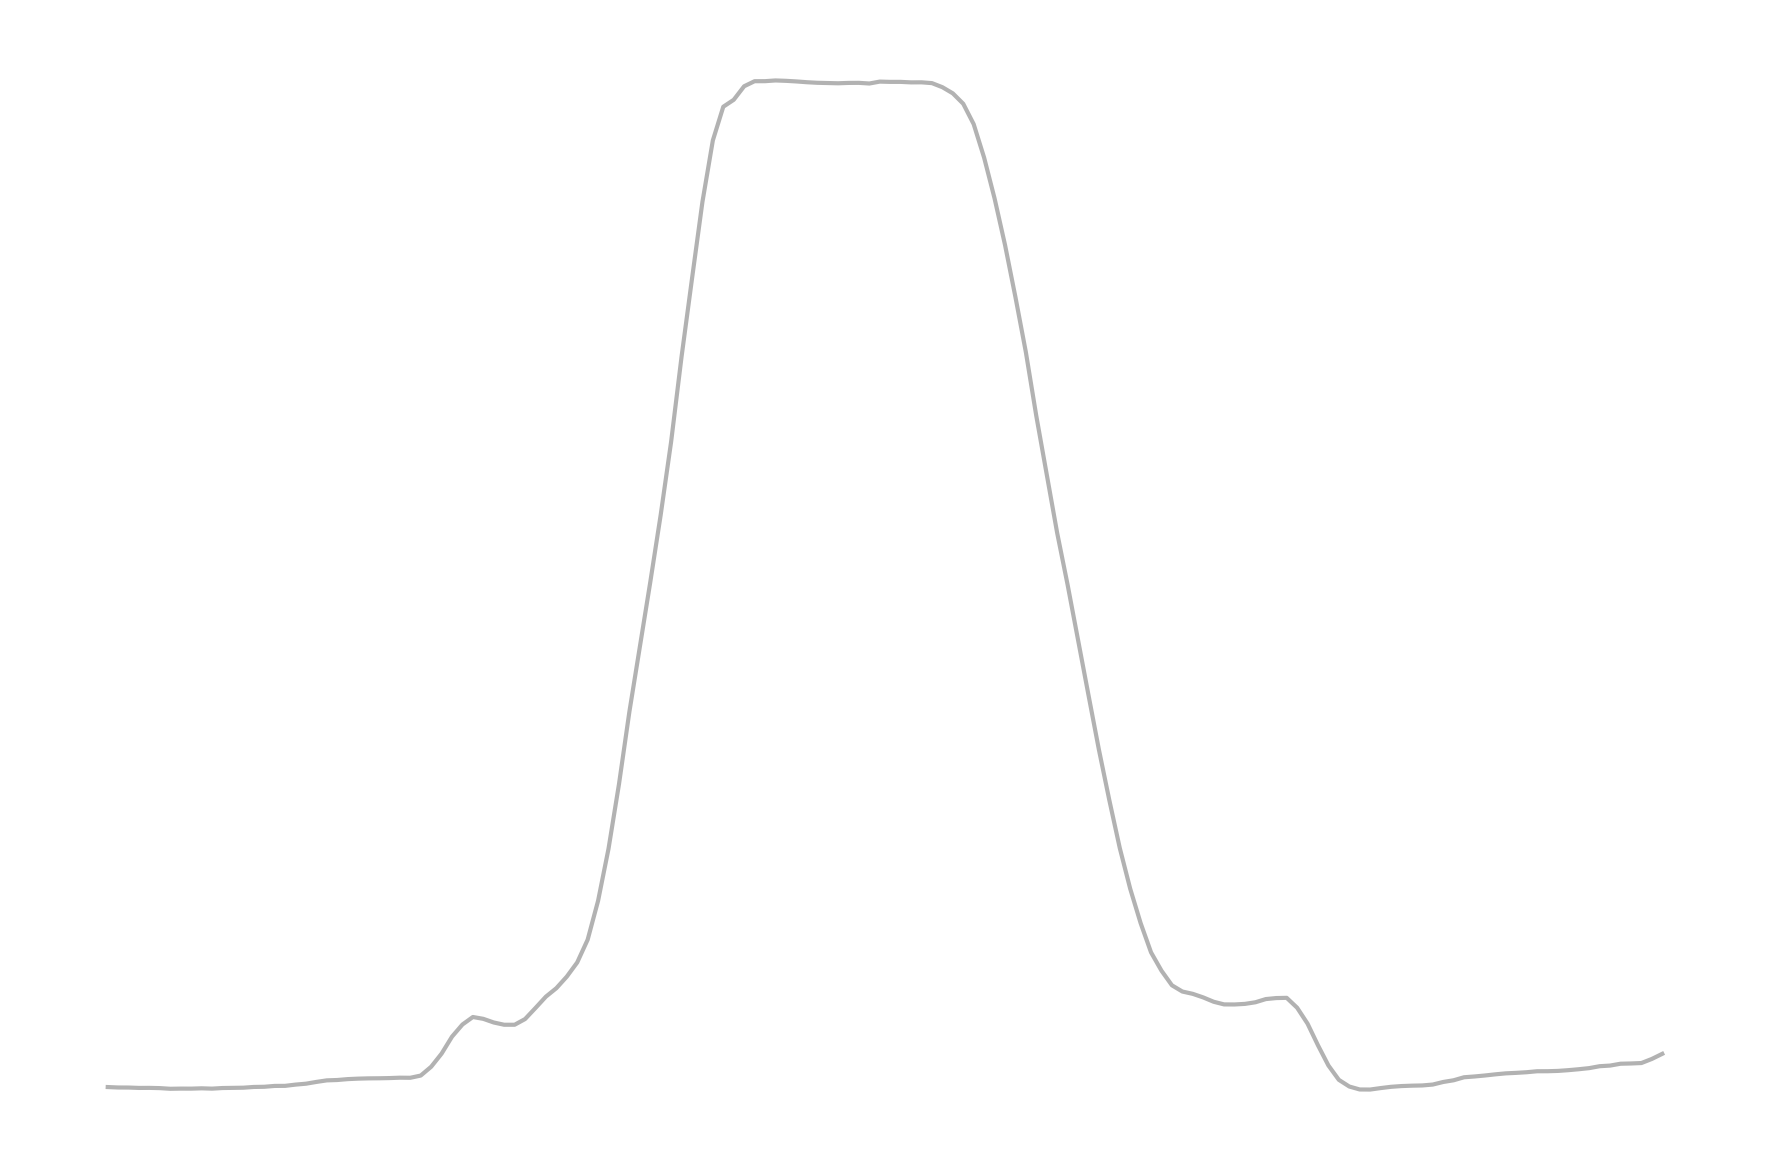

(<matplotlib.colors.Normalize at 0x7f9a234bfe90>, 5.515160198596295)

In [5]:
save_dir = './figure/ProcessExample/'
implets_save_dir = f'./output/{model_name}/{task}/{explainer}'
implets_list = pickle_load_from_file(os.path.join(implets_save_dir, 'implets.pkl'))

implets_class0 = implets_list['implets_class0']
implets_class1 = implets_list['implets_class1']

sample_id_selected = 4
print(f'Pred y:{test_y[sample_id_selected]}')
# plt.plot(test_x[sample_id_selected].flatten())
# save_path=save_dir+'inst'+str(sample_id_selected)+'.png'
save_path = None
visual_inst(test_x[sample_id_selected], save_path=save_path, figsize=None, title=None)

implets_same_samples = []
for implet in implets_class0:
    sample_id, implet_vals, implet_attr, score, start_loc, end_loc = implet
    # print(sample_id)
    if sample_id == sample_id_selected:
        plt.plot(np.arange(start_loc, end_loc + 1), implet_vals.flatten(), color='orange')
        implets_same_samples.append(implet)

save_path=save_dir+'implet'+str(sample_id_selected)+'.png'
# save_path = None
plot_implet_clusters_with_instances(implets_same_samples, test_x[sample_id_selected], save_path=save_path)
save_path=save_dir+'attr'+str(sample_id_selected)+'.png'
visual_attribution(test_x[sample_id_selected], attr_gp[sample_id_selected],  alpha=1.0, lw=1.0,save_path=save_path)



In [6]:
def plot_attribution(item, exp, figsize=(6.4, 4.8), normalize_attribution=True, save_path=None, title=""):
    """
    Plots explanation on the explained Sample.

    Arguments:
        item np.array: instance to be explained,if `mode = time`->`(1,time,feat)`  or `mode = feat`->`(1,feat,time)`.
        exp np.array: explanation, ,if `mode = time`->`(time,feat)`  or `mode = feat`->`(feat,time)`.
        figsize (int,int): desired size of plot.
        heatmap bool: 'True' if only heatmap, otherwise 'False'.
        save str: Path to save figure.
    """
    if len(item[0]) == 1:
        test = item[0]
        # if only one-dimensional input
        fig, (axn, cbar_ax) = plt.subplots(
            len(item[0]), 2, sharex=False, sharey=False, figsize=figsize, gridspec_kw={'width_ratios': [40, 1]},
        )

        # Shahbaz: Set color pallete such that negative is red and positive is blue
        my_cmap = sns.diverging_palette(260, 10, as_cmap=True)

        #set min and max to have same absolute values
        extremum = np.max(abs(exp))

        # cbar_ax = fig.add_axes([.91, .3, .03, .4])
        axn012 = axn.twinx()
        if normalize_attribution:
            sns.heatmap(
                exp.reshape(1, -1),
                fmt="g",
                cmap=my_cmap,
                ax=axn,
                yticklabels=False,
                vmin=-1*extremum,
                vmax=extremum,
                cbar_ax=cbar_ax,
                # cbar_kws={"orientation": "vertical"},
            )
        else:
            sns.heatmap(
                exp.reshape(1, -1),
                fmt="g",
                cmap="viridis",
                ax=axn,
                yticklabels=False,
                vmin=0,
                vmax=1,
            )
        sns.lineplot(
            x=np.arange(0, len(item[0][0].reshape(-1))) + 0.5,
            y=item[0][0].flatten(),
            ax=axn012,
            color="black",
        )
        # plt.subplots_adjust(wspace=0, hspace=0, left=0.02, right=0.95, top=0.95, bottom=0.05)
        cbar_ax.tick_params(labelsize=10)
        plt.title(title)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    else:
        ax011 = []

        fig, axn = plt.subplots(
            len(item[0]), 1, sharex=True, sharey=True, figsize=figsize
        )
        cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

        for channel in item[0]:
            # print(item.shape)
            # ax011.append(plt.subplot(len(item[0]),1,i+1))
            # ax012.append(ax011[i].twinx())
            # ax011[i].set_facecolor("#440154FF")
            axn012 = axn[i].twinx()
            if normalize_attribution:

                sns.heatmap(
                    exp[i].reshape(1, -1),
                    fmt="g",
                    cmap="viridis",
                    cbar=i == 0,
                    cbar_ax=None if i else cbar_ax,
                    ax=axn[i],
                    yticklabels=False,
                    vmin=np.min(exp),
                    vmax=np.max(exp),
                )
            else:
                sns.heatmap(
                    exp[i].reshape(1, -1),
                    fmt="g",
                    cmap="viridis",
                    cbar=i == 0,
                    cbar_ax=None if i else cbar_ax,
                    ax=axn[i],
                    yticklabels=False,
                    vmin=0,
                    vmax=1,
                )

            sns.lineplot(
                x=range(0, len(channel.reshape(-1))),
                y=channel.flatten(),
                ax=axn012,
                color="white",
            )
            plt.xlabel("Time", fontweight="bold", fontsize="large")
            plt.ylabel(f"Feature {i}", fontweight="bold", fontsize="large")
            i = i + 1
        fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.axis("off")  
    if save_path is not None:
        path_only = save_path.rsplit("/", 1)[0] + "/"
        create_path_if_not_exists(path_only)
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

In [7]:

# print(extremum)

In [8]:
# for implate_name, implets_class_i in implets_list.items():

implet_name = 'implets_class0'
implets_class_i = implets_class0
cluster_path = os.path.join(implets_save_dir, f'{implet_name}_cluster_results.pkl')
# print(cluster_path)
implet_cluster_results = pickle_load_from_file(cluster_path)
best_indices_dep = implet_cluster_results['best_indices_dep']
best_centroids_dep = implet_cluster_results['best_centroids_dep']
best_k_dep = implet_cluster_results['best_k_dep']

# print(best_indices_dep,best_centroids_dep,best_k_dep)
# print(implets_save_dir, implate_name, best_k_dep)
# print(implet_cluster_results['best_centroids_dep'])

attrs = np.concatenate([np.abs(imp[2]).flatten() for imp in implets_class_i])
extremum = np.mean(attrs) + 3*np.std(attrs)
norm = mcolors.Normalize(vmin=-extremum, vmax=extremum)
            

for clsuster_i in range(best_k_dep):

    implet_indexes = list(best_indices_dep[clsuster_i])
    # print(implet_indexes)
    implet_cluster = [implets_class_i[idx] for idx in implet_indexes]

    # implet_with_attr = [np.vstack((imp[1], imp[2])).T for imp in implet_cluster]

    instances_num = list(set([imp[0] for imp in implet_cluster]))
    instances_num.sort()
    # print(implet_with_attr, instances_num)
    save_path = save_dir+'cluster'+str(clsuster_i)+'.png' #
    plot_implet_clusters_with_instances(implet_cluster, test_x[instances_num], save_path=save_path)
        

In [9]:
tasks+tasks_new

['GunPoint',
 'Strawberry',
 'ECG200',
 'DistalPhalanxOutlineCorrect',
 'PowerCons',
 'Earthquakes',
 'Coffee',
 'Chinatown',
 'Computers',
 'ECGFiveDays',
 'TwoLeadECG',
 'Lightning2',
 'FordA',
 'GunPointMaleVersusFemale']

# 03192025

GunPoint implets_class0
3.6400701397719484 5.786491182089097


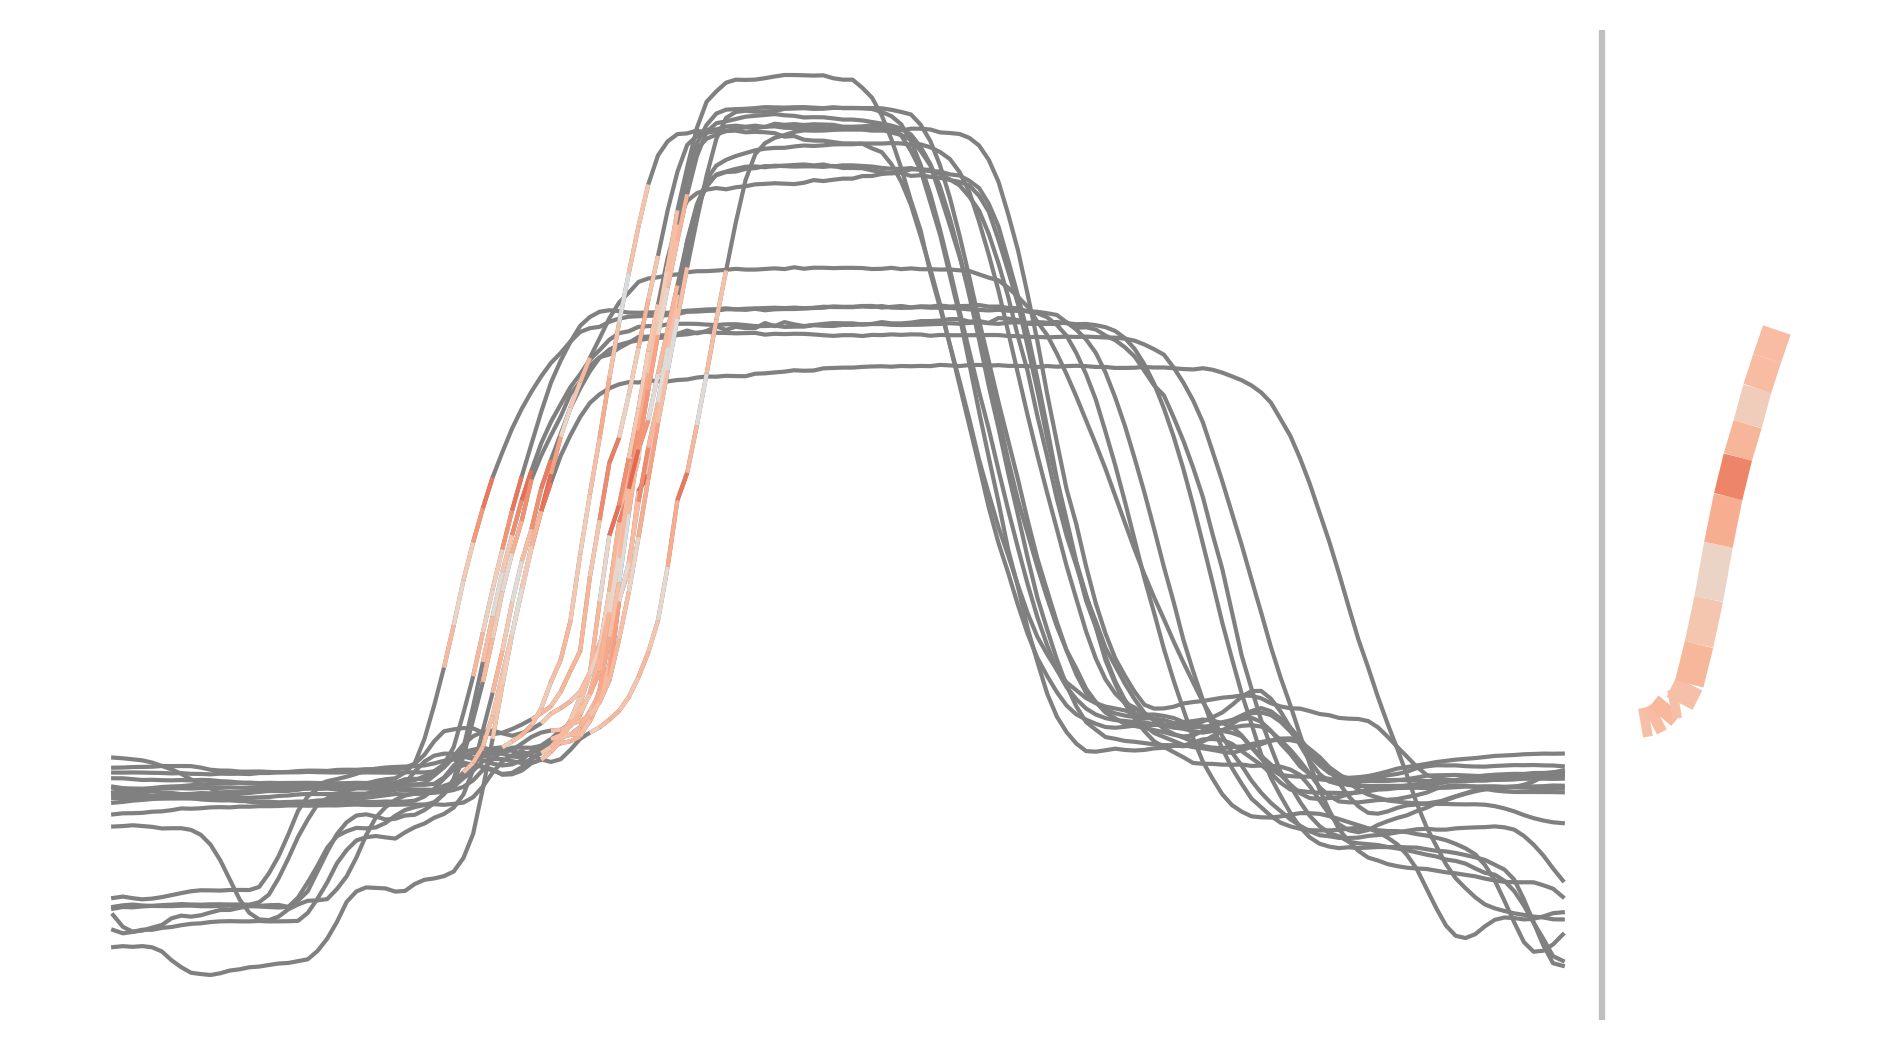

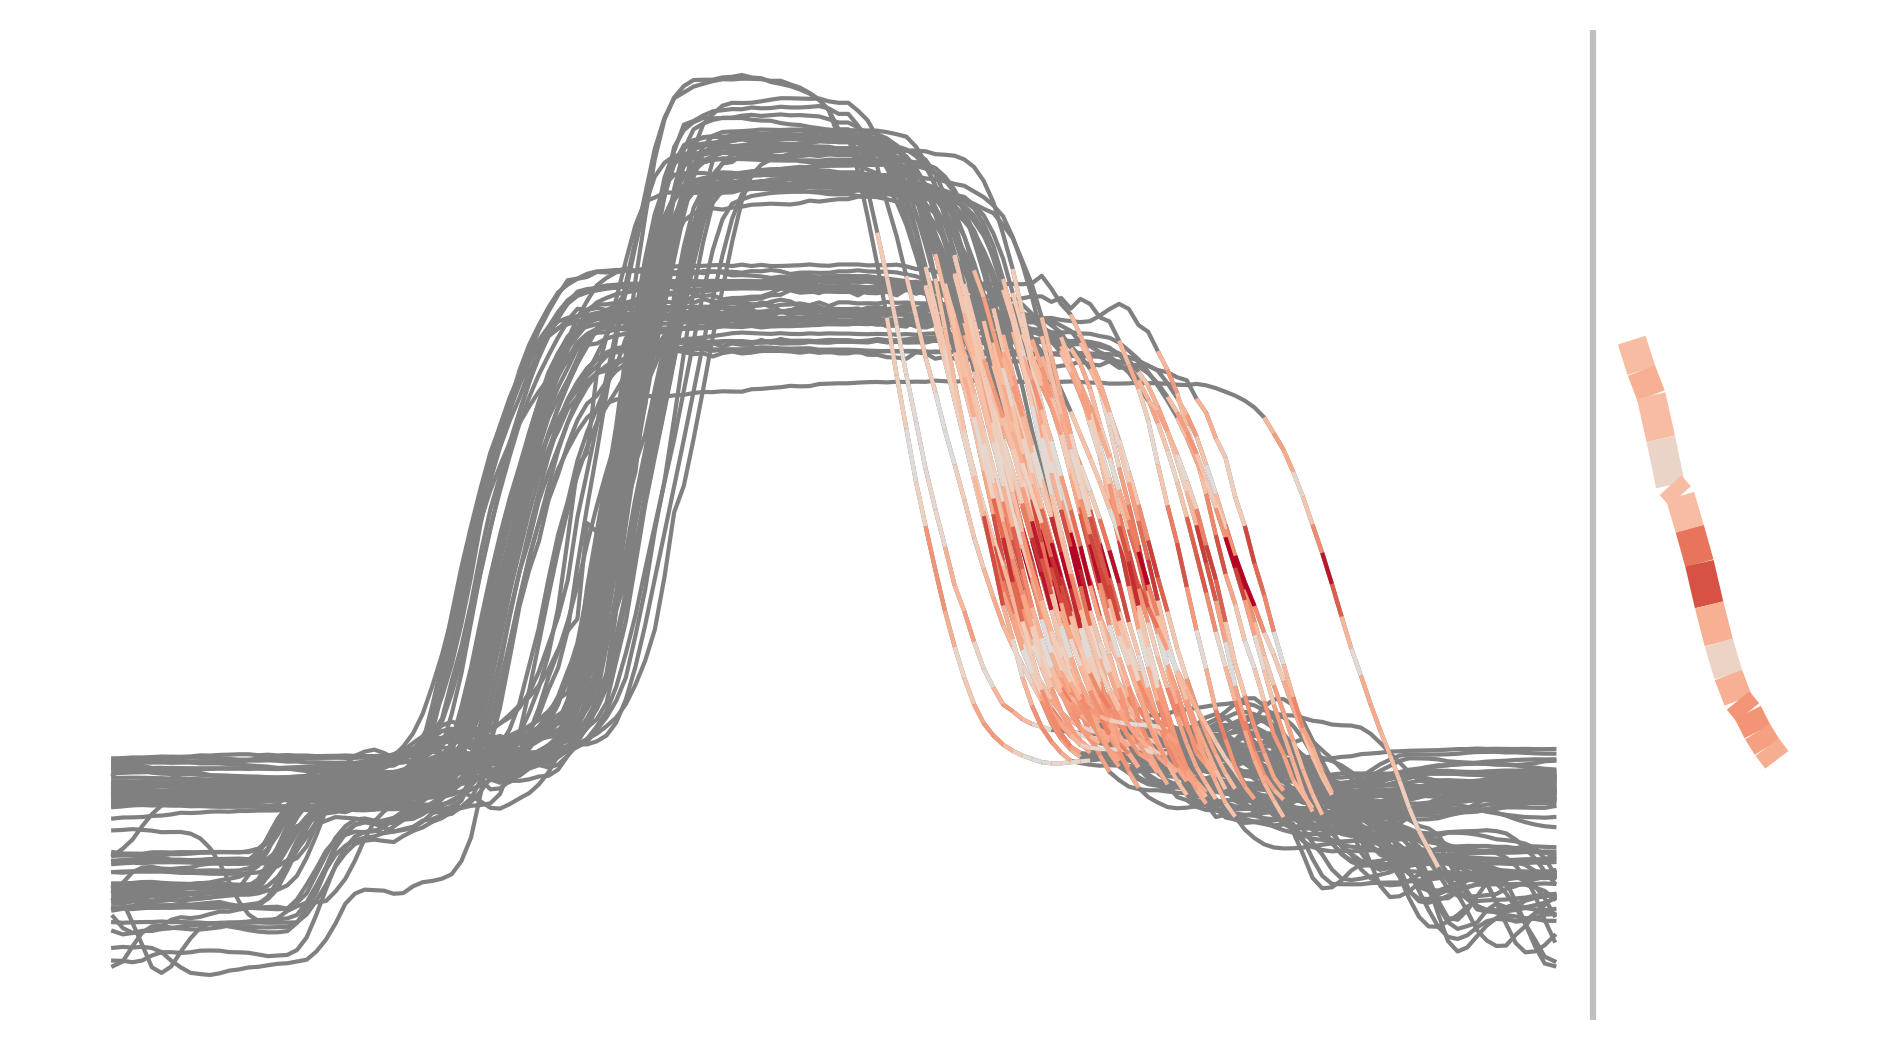

GunPoint implets_class1
2.5996456368457155 4.462320405159439


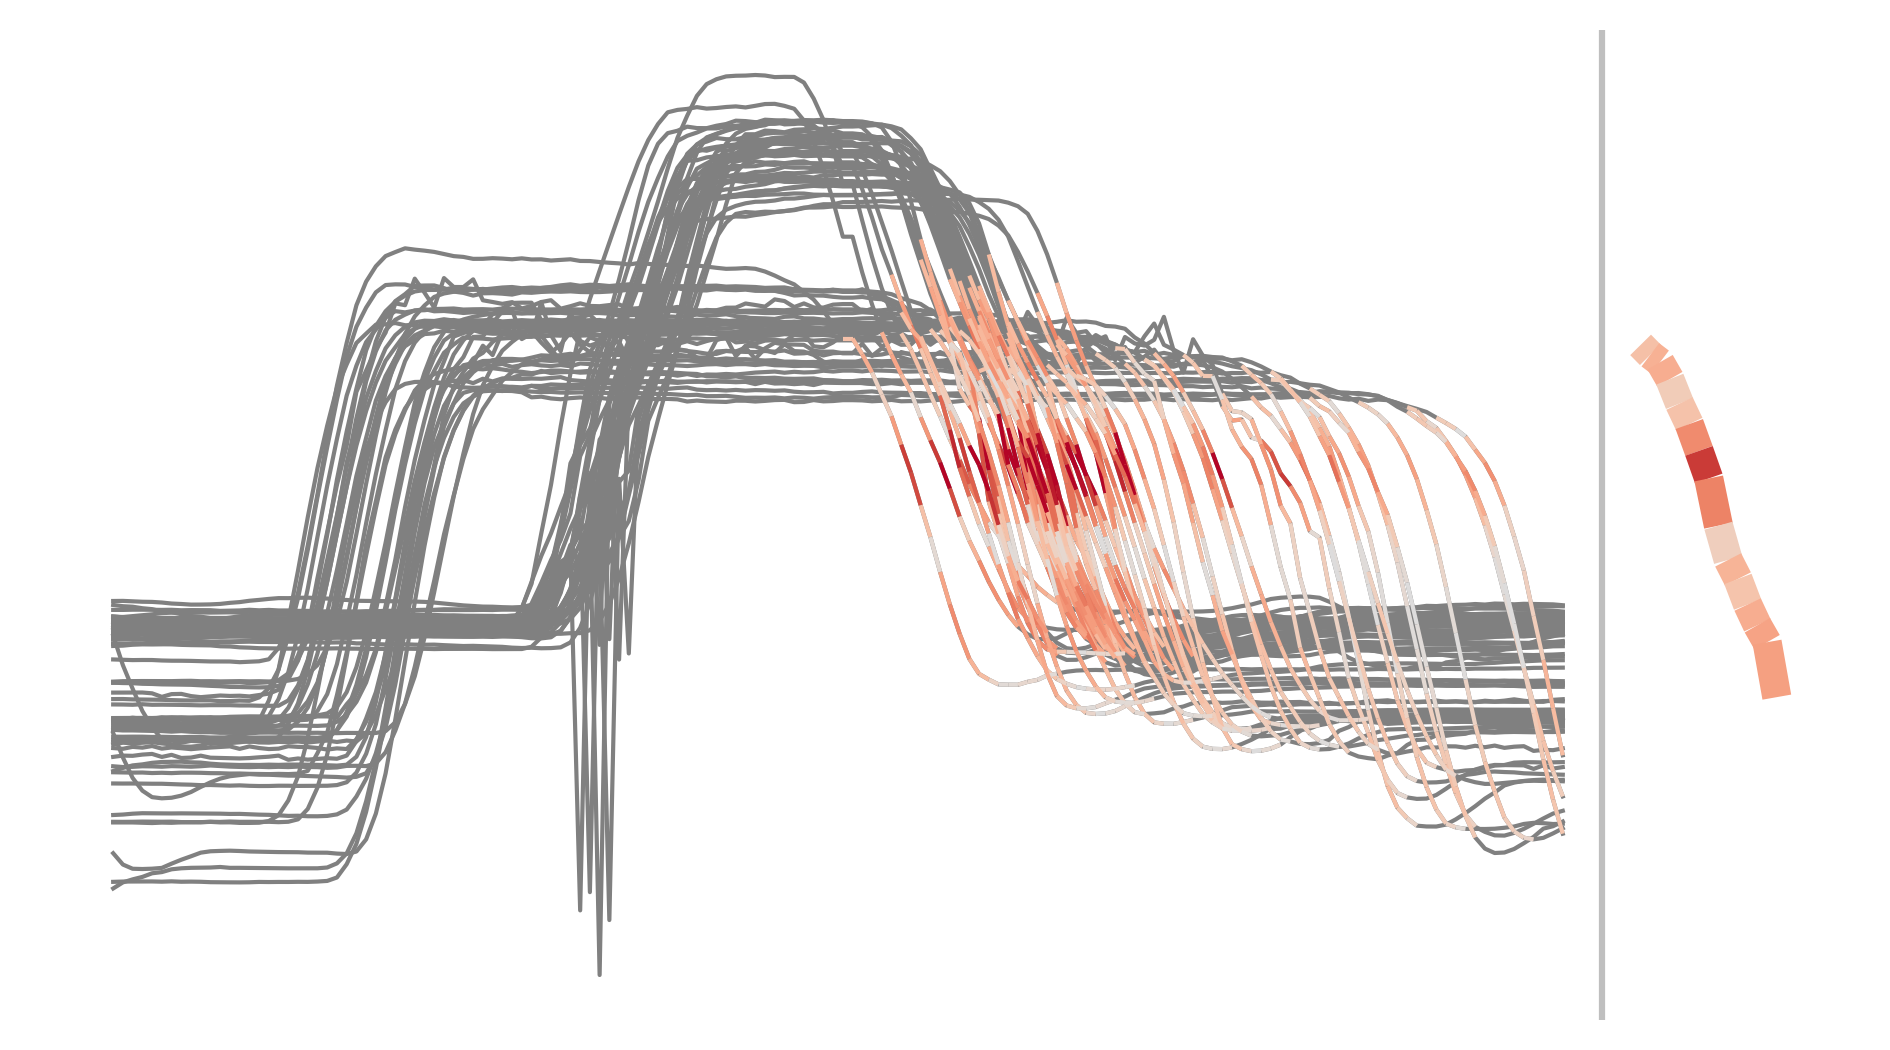

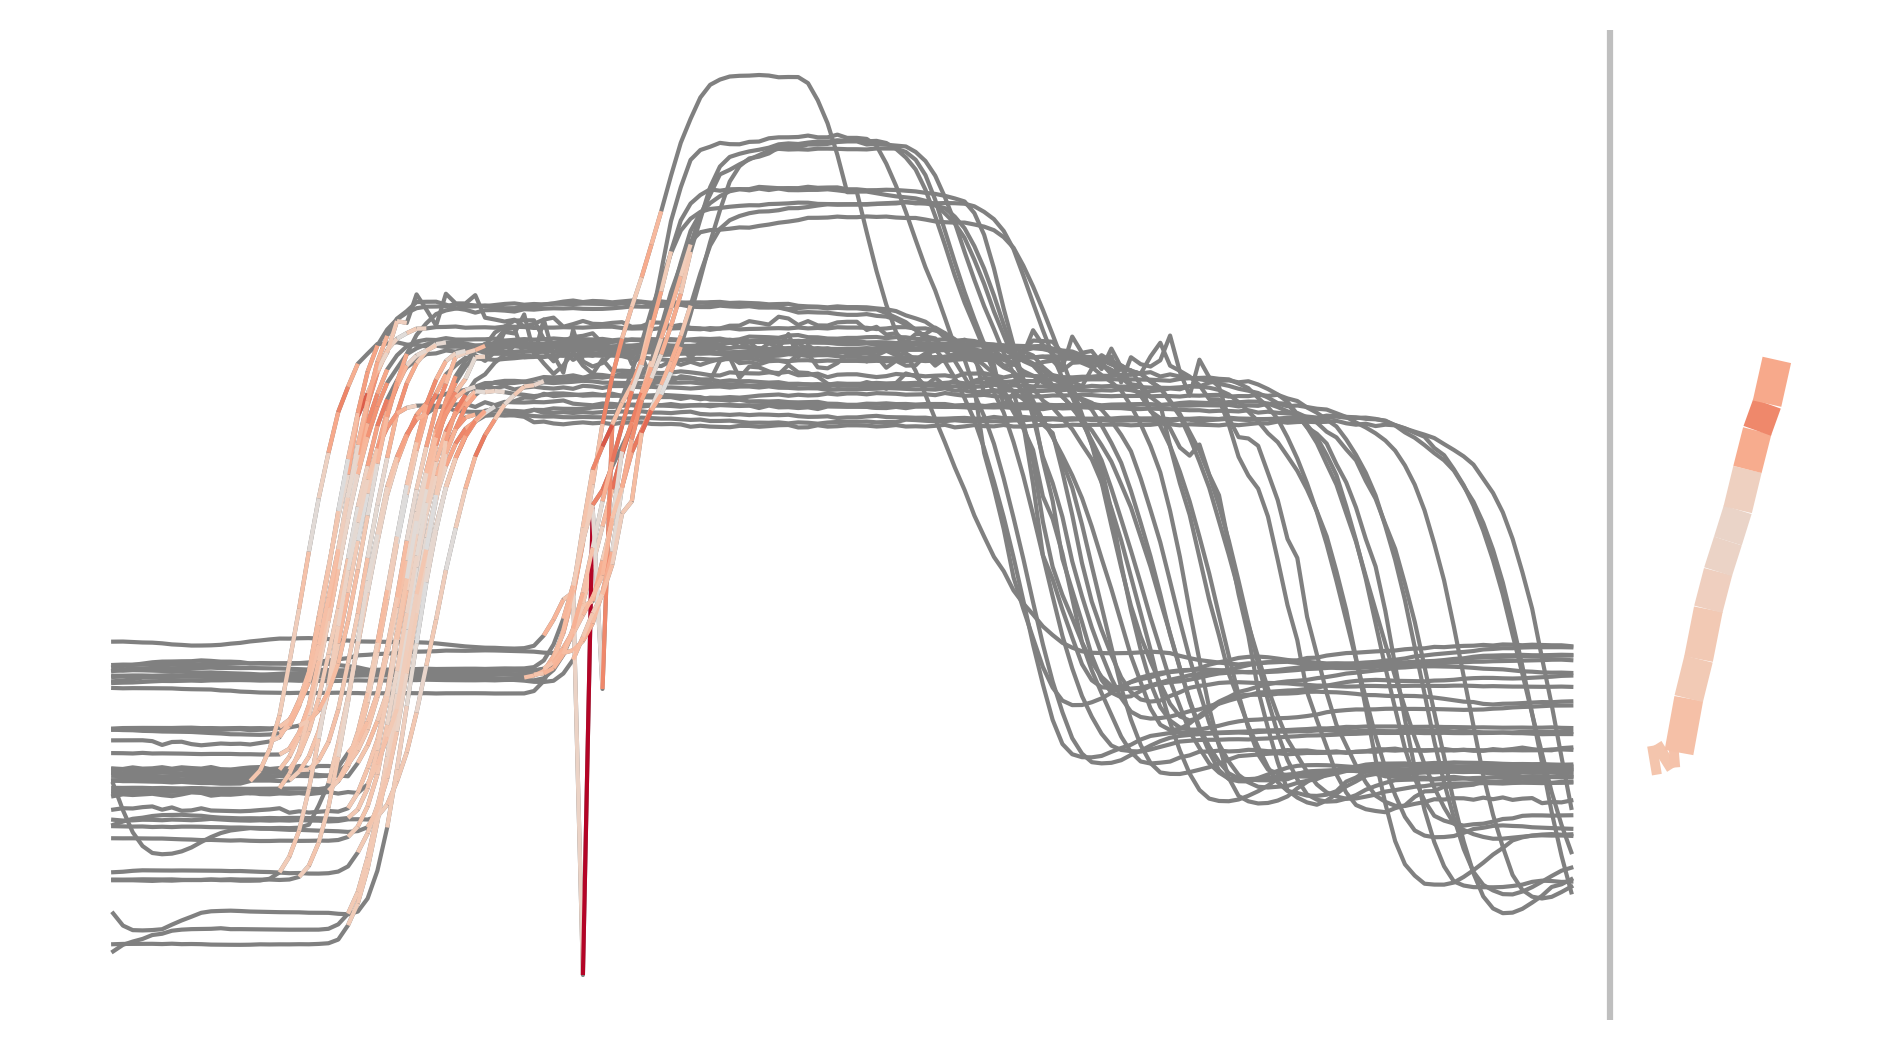

In [47]:
import matplotlib.colors as mcolors

model_name = 'FCN'
explainer = 'Saliency'
k = 2
all_tasks = ['GunPoint']#tasks + tasks_new
for task in all_tasks:

    train_x, test_x, train_y, test_y, enc1 = read_UCR_UEA(task, None)
    test_y = np.argmax(test_y, axis=1)
    train_y = np.argmax(train_y, axis=1)
    preds = np.load(f'{model_path}/test_preds.npy')
    save_dir = './figure/ProcessExample/'
    implets_save_dir = f'./output/{model_name}/{task}/{explainer}' if k is None else f'./output/k{k}/{model_name}/{task}/{explainer}'
    implets_list = pickle_load_from_file(os.path.join(implets_save_dir, 'implets.pkl'))
    
    # implets_class0 = implets_list['implets_class0']
    # implets_class1 = implets_list['implets_class1']
    

    
    for implet_name, implets_class_i in implets_list.items():
        print(task,implet_name)

        
        cluster_path = os.path.join(implets_save_dir, f'{implet_name}_cluster_results.pkl')
        implet_cluster_results = pickle_load_from_file(cluster_path)
        best_indices_dep = implet_cluster_results['best_indices_dep']
        best_centroids_dep = implet_cluster_results['best_centroids_dep']
        best_k_dep = implet_cluster_results['best_k_dep']

        attrs = np.concatenate([np.abs(imp[2]).flatten() for imp in implets_class_i])
        print(np.mean(attrs), np.mean(attrs) +  np.std(attrs))
        extremum = np.mean(attrs) + 3*np.std(attrs)
        norm = mcolors.Normalize(vmin=-extremum, vmax=extremum)
            
        if best_k_dep is None:
            continue
        for clsuster_i in range(best_k_dep):
    
            
            implet_indexes = list(best_indices_dep[clsuster_i])
            # print(implet_indexes)
            implet_cluster = [implets_class_i[idx] for idx in implet_indexes]

            centroid = best_centroids_dep[clsuster_i]
        
            # implet_with_attr = [np.vstack((imp[1], imp[2])).T for imp in implet_cluster]
        
            instances_num = list(set([imp[0] for imp in implet_cluster]))
            instances_num.sort()
            # print(implet_with_attr, instances_num)
            #save_path = save_dir+ task +'/'+implet_name+'_cluster'+str(clsuster_i)+'.png' #save_dir+'cluster'+str(clsuster_i)+'.png' #

            save_path = save_dir+ task +'_k'+str(k)+'/'+implet_name+'_cluster'+str(clsuster_i)+'.png'
            
            plot_implet_clusters_with_instances(implet_cluster, test_x[instances_num], norm=norm, centroid=centroid, figsize=(6.4, 3.6))
            # save_path = None
            # norm = plot_implet_clusters_with_instances(implet_cluster, test_x[instances_num], save_path=save_path)

            # attrs = np.concatenate([np.abs(imp[1]).flatten() for imp in implet_cluster])
            # print(attrs.shape)